In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
sns.set()

In [3]:
def create_data(N=1000):
    Y = np.vstack([np.random.normal([3, 8], [1, 3], (N // 2, 2)),
                   np.random.normal([8, 3], [3, 1], (N - N // 2, 2))])
    X = np.vstack([0.1 * Y[:, 0] * Y[:, 1],
                   np.sin(Y[:, 0]) * np.cos(Y[:, 1]),
                   np.cos(Y[:, 0]) * np.sin(Y[:, 1])]).T
    X = np.random.normal(X, 1.0)
    return X, Y

In [4]:
np.random.seed(0)
X, Y = create_data(1000)

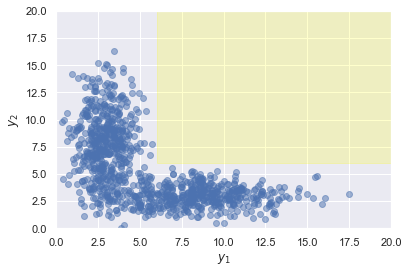

In [5]:
fig, ax = plt.subplots()
ax.plot(Y[:, 0], Y[:, 1], 'o', alpha=0.5)
ax.add_patch(plt.Rectangle((6, 6), 14, 14, color='yellow', alpha=0.2))
ax.set_xlim(0, 20); ax.set_ylim(0, 20)
ax.set_xlabel('$y_1$'); ax.set_ylabel('$y_2$');

In [16]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=0.5)

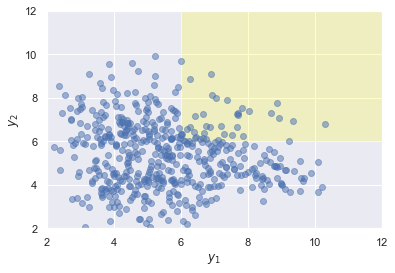

In [17]:
from sklearn.ensemble import RandomForestRegressor

clf1 = RandomForestRegressor(100).fit(Xtrain, Ytrain)
Ypred1 = clf1.predict(Xtest)

fig, ax = plt.subplots()
ax.plot(Ypred1[:, 0], Ypred1[:, 1], 'o', alpha=0.5)
ax.add_patch(plt.Rectangle((6, 6), 14, 14, color='yellow', alpha=0.2))
ax.set_xlim(2, 12); ax.set_ylim(2, 12)
ax.set_xlabel('$y_1$'); ax.set_ylabel('$y_2$');

In [18]:
class MultiOutputRF(object):
    def __init__(self, *args, **kwargs):
        self.args = args
        self.kwargs = kwargs
        
    def fit(self, X, Y):
        X, Y = map(np.atleast_2d, (X, Y))
        assert X.shape[0] == Y.shape[0]
        Ny = Y.shape[1]
        
        self.clfs = []
        for i in range(Ny):
            clf = RandomForestRegressor(*self.args, **self.kwargs)
            Xi = np.hstack([X, Y[:, :i]])
            yi = Y[:, i]
            self.clfs.append(clf.fit(Xi, yi))
            
        return self
        
    def predict(self, X):
        Y = np.empty([X.shape[0], len(self.clfs)])
        for i, clf in enumerate(self.clfs):
            Y[:, i] = clf.predict(np.hstack([X, Y[:, :i]]))
        return Y

array([[ 3.04438379e+00,  2.30987731e-01, -1.98886705e+00],
       [ 1.45979864e-01, -1.56605743e+00,  1.30770576e+00],
       [ 4.03740706e+00,  4.56501816e-01,  4.66084567e-01],
       ...,
       [ 2.40683286e+00,  4.23096970e-01, -7.81596718e-02],
       [-2.34157107e-01,  8.81698060e-01, -6.41426046e-01],
       [-7.89073944e-04, -4.18675546e-01, -2.58072123e-01]])

In [22]:
type(Xtrain)

numpy.ndarray

In [19]:
clf2 = MultiOutputRF(100).fit(Xtrain, Ytrain)
Ypred2 = clf2.predict(Xtest)

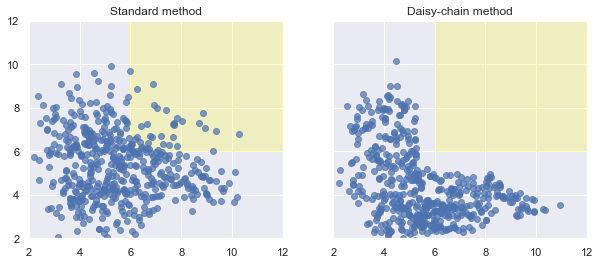

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
    
ax[0].plot(Ypred1[:, 0], Ypred1[:, 1], 'o', alpha=0.7)
ax[1].plot(Ypred2[:, 0], Ypred2[:, 1], 'o', alpha=0.7)

ax[0].set_title("Standard method")
ax[1].set_title("Daisy-chain method")

for axi in ax:
    axi.add_patch(plt.Rectangle((6, 6), 14, 14, color='yellow', alpha=0.2))
    axi.set_xlim(2, 12)
    axi.set_ylim(2, 12)